In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from collections import Counter

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score,accuracy_score
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from hyperopt import STATUS_OK,Trials, fmin, hp, tpe


In [52]:
red_train = pd.read_csv("data/red_wine_train.csv",index_col=0)
red_test = pd.read_csv("data/red_wine_test.csv",index_col=0)

In [53]:
red_train.describe()

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality,alcohol_higher,va_high
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,8.312353,0.526818,0.270594,0.088159,46.181392,0.996746,0.658843,10.438911,5.637217,0.158718,0.344019
std,1.738059,0.179418,0.195804,0.049180,32.769688,0.001902,0.168077,1.065957,0.808633,0.365556,0.475233
min,4.700000,0.120000,0.000000,0.012000,6.000000,0.990070,0.330000,8.400000,3.000000,0.000000,0.000000
25%,7.100000,0.390000,0.100000,0.070000,22.000000,0.995600,0.550000,9.500000,5.000000,0.000000,0.000000
50%,7.900000,0.520000,0.260000,0.080000,37.000000,0.996800,0.620000,10.200000,6.000000,0.000000,0.000000
75%,9.200000,0.635000,0.420000,0.090000,62.000000,0.997890,0.730000,11.100000,6.000000,0.000000,1.000000
max,15.900000,1.580000,1.000000,0.611000,289.000000,1.003690,2.000000,14.900000,8.000000,1.000000,1.000000


First Attempt: outlier removal, and dropping fixed acidity and chlordies, and the two binary variables (no binning)

In [54]:
red_train = red_train.drop(["alcohol_higher", "va_high"], axis=1)
red_test= red_test.drop(["alcohol_higher", "va_high"], axis=1)

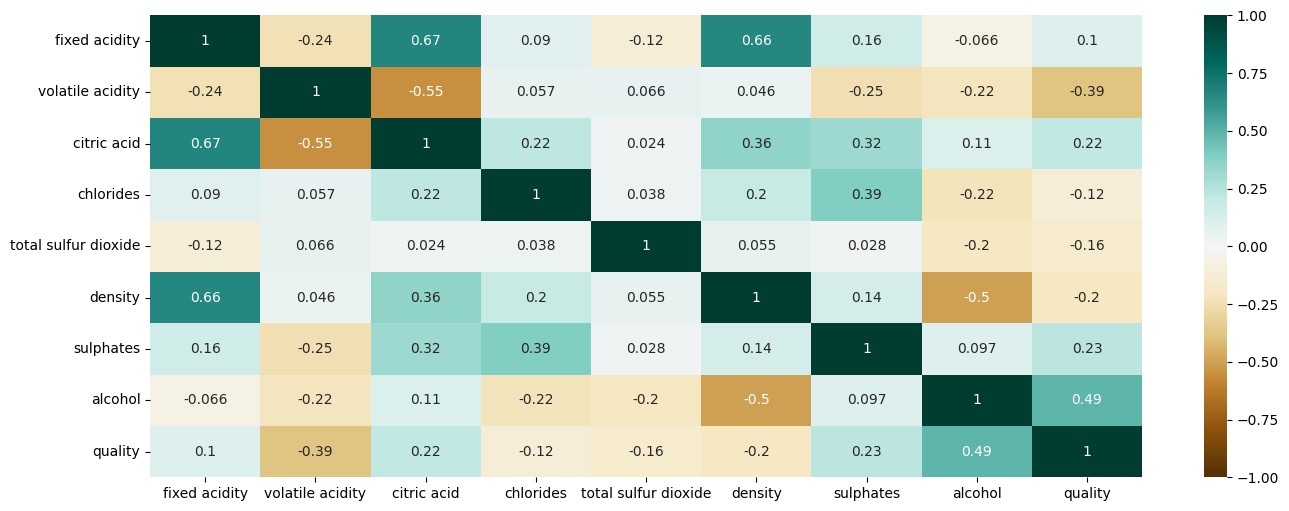

In [55]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(red_train.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

---
Preprocessing

For decision trees, there typically no reason to do much when it comes to altering the data. Decision trees do not have much problems with scaled, normalized, and other types continous data is not a big deal (especially with XGB). If we had categorical data, this would be different, espcially if we had to data cleanup, but other than outliers there is not much that can more be done that what is given.

In [56]:
def remove_outliers(df: pd.DataFrame, n :float, columns):
    #this is the Tukey method which gets the values that exists outside of the outer fence of a histogram of a particular value
    #This is valuale if outliers effect the data alot (typically regression), in classification this might be different
    #Classifiaction in imbalanced datasets (like this one), might need outliers, so I am going to try with both

    total_outliers = []

    for col in columns:

        #generating the quantile ranges that will be used to determine outliers
        q1 = df[col].quantile(.25)
        q3 = df[col].quantile(.75)

        iqr = q3 - q1
        outer_fence = iqr * 1.5

        outliers = df[(df[col] < q1 - outer_fence) | (df[col] > q3 + outer_fence)].index

        total_outliers.extend(outliers)

    #select the indexes (tuples) that have more than n attributes that are outliers (can scale)
    outliers = Counter(total_outliers)
    multiple_outliers = list(k for k , v in outliers.items() if v > n)


    return multiple_outliers

In [57]:
#chose two as during Eda it seemed that individually there was not much outliers and there were alot of important ones (our negative class 1)
outliers = remove_outliers(red_train, 2 , red_train.columns[:-1])
red_train = red_train.drop(outliers, axis = 0).reset_index(drop=True)
red_train

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality
0,6.4,0.42,0.09,0.054,64.0,0.99724,0.68,10.4,6
1,6.9,0.58,0.01,0.080,54.0,0.99683,0.73,9.7,5
2,5.9,0.29,0.25,0.067,160.0,0.99721,0.54,10.3,6
3,8.4,0.37,0.43,0.063,19.0,0.99550,0.81,11.2,7
4,8.8,0.61,0.30,0.088,46.0,0.99760,0.51,9.3,4
...,...,...,...,...,...,...,...,...,...
1271,9.9,0.72,0.55,0.136,52.0,0.99752,0.94,10.0,5
1272,12.3,0.39,0.63,0.091,18.0,1.00040,0.49,9.5,5
1273,7.6,0.54,0.13,0.097,66.0,0.99785,0.61,9.4,5
1274,7.1,0.43,0.42,0.070,129.0,0.99730,0.72,10.5,5


---
Model Testing

In [58]:
X_train = red_train.drop("quality" , axis=1)
y_train = red_train["quality"]
X_test = red_test.drop("quality" , axis=1).copy()
y_test = red_test["quality"]

In [59]:
#xgb expects only what is present, not the actual scale of the data relative to quality (1-10)
#therefore, we have to map to values 0-5 for the scale 
y_train = y_train.map({3: 0, 4: 1, 5:2, 6:3, 7:4, 8:5})
y_test = y_test.map({3: 0, 4: 1, 5:2, 6:3, 7:4, 8:5})

Hyper parameters:

    Booster: choose the type of booster to use (we will use tree in this case)
        -- 3 options 
        tree( gbtree,dart)
        linear(gblinear)

    Booster Parameters: only the tree booster ones, only listing the ones usuful to mulitlable imbalanced data (trees for the win)

        -- eta: the learning rat for Gradient boosting, and its range typically is 0.01 - 0.2
        -- gamma: how the node is split in a tree, the larger the more conservative a tree is, range(0 --> infinity)
        -- max_depth: maximum depth of a tree typical values are (3-10), should use cv
        -- min_child_weight: tune using cv but range is 0-->infinite
        -- subsample: fraction of observations to be samples for tree, lower values more conservative, typical values (0,1)
        -- colsample_bytree: ratio of columns when construction each tree
        -- tree method: constuction algorithm used in model (multiple choices)
        -- max_leaves: is maximum number of nodes to be added

        Others
        -- alpha : used for lasso regression, increasing makes the model more conservative
        -- lambda : used for ridge regression, increasing makes the model more conservative

    Learning Task: parameters used to define the optimization objective for learning 
        
        --objective: should use multi:softprob or multi: softmax
        --eval metric: should use auc, or merror

Hyperopt

    -- uses bayesian optimization to find the best parameter for machine learning algorithm, by using probablistic search of the hyperparamters supplied
       Compared to exahustive search it is much faster and its performance is only a bit lower

    How to implement:
        1. intitalise the domain space (same as a grid search)
        2. define the objective function  that we want to minimze (error rate) of the model that we are testing (XGBoost decision trees in this case)
        3. Optimize alogirhtm choice (the method used to construct the surrogate objective function)
        4. Results, the score or the value pairs that the algorithm uses to build the model

In [60]:
space = {"max_depth":hp.quniform("max_depth",3,18,1),
         "gamma" : hp.uniform('gamma',1,9),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=red_train["quality"]
)



Available optimizaiton algorithms:

    -- hp.choice(label,options) : returns a choice of one of the options

    -- hp.randint(label,upper) : returns a random integer better range of 0 --> upper

    -- hp.uniform(label,low, high) : returns a value uniformly between the low and high

    -- hp.uniform(label,low,high,q) : returns a value round to (uniforn(low,high)/q) , and returns an integer

    -- hp.normal(label,mean,std) : returns a real value that is normally distributed with mean and standard deviation


In [61]:
def ojective(space:dict):
        #creating a classifer with the opametrs pulled from the space that has been already been listed. 
        #Most explanation is above
        clf=XGBClassifier(
                n_estimators =space['n_estimators'],
                max_depth = int(space['max_depth']),
                gamma = space['gamma'],
                min_child_weight=int(space['min_child_weight']),
                colsample_bytree=int(space['colsample_bytree']),
                objective="multi:softprob",
                early_stopping_rounds=10,eval_metric="auc")

        #evalutation train set and test set for doing a fit 
        evaluation = [( X_train, y_train), ( X_test, y_test)]

        clf.fit(X_train,y_train,eval_set=evaluation,
                verbose=False,
                sample_weight=classes_weights)
        

        y_pred = clf.predict(X_test)
        accuracy = f1_score(y_test,y_pred,average="micro")
        print("SCORE:" + str(accuracy))
        return {'loss' : -accuracy, "status" : STATUS_OK}

Trials:

-- an object that contains or stores all the relevent information such as a hyperparameter. The loss functions for each type of parameter is stored
     here. Whenever doing iterations of training with current hyperparameters.

-- fmin is an optimization function that minimizes the loss function for each paramter inside of space.

-- algo: The type of the algorithm for finding best hyperparamter. Tpe is a type of decision tree, so effectively we are using a decision tree to 
            do the hyperparamter choosing.
            
-- max evals: the amount of iterations that we choose to run through
     

In [62]:
trials = Trials()


best_hyperparams = fmin(fn = ojective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

SCORE:0.525                                           
SCORE:0.55625                                                       
SCORE:0.471875                                                        
SCORE:0.55625                                                         
SCORE:0.515625                                                        
SCORE:0.490625                                                        
SCORE:0.459375                                                        
SCORE:0.45625                                                         
SCORE:0.48125000000000007                                             
SCORE:0.559375                                                        
SCORE:0.515625                                                          
SCORE:0.440625                                                          
SCORE:0.496875                                                          
SCORE:0.46875                                                           
SCORE:0.465625  

In [68]:
best_hyperparams ={'colsample_bytree': 0.8412453662794159,
 'gamma': 1.1691640644581476,
 'max_depth': 6.0,
 'min_child_weight': 4.0}

In [69]:
#fitting with 
accuracies = []
for i in range(0,5):
    model=XGBClassifier(
        n_estimators=180, max_depth = int(best_hyperparams['max_depth']),
        gamma = best_hyperparams['gamma'],min_child_weight=int(best_hyperparams['min_child_weight']),
        colsample_bytree=int(best_hyperparams['colsample_bytree']),objective="mult:softprob",eval_metric="auc",seed=i)


    model.fit(X_train, y_train,
            verbose=False)

    y_pred = model.predict(X_test)

    accuracies.append(f1_score(y_test,y_pred,average="micro"))

accuracies

[0.6375, 0.625, 0.64375, 0.615625, 0.65]

In [70]:
average_score= np.mean(accuracies)

In [71]:
average_score

0.634375